In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
def GaussianNoise(u,sigma,x):
  noise = (1/(sigma*(2*np.pi)**(1/2)))*np.exp(-(1/2)*((x-u)/sigma)**2)
  return noise

In [3]:
X=[]
y=[]
for i in range(1,100):
  X.append(i)
  y.append(i*i + GaussianNoise(0,1,i*i))


In [4]:
df = pd.DataFrame()
df['X']=X
df['y']=y

df

,X,y
0,1,1.241971
1,2,4.000134
2,3,9.000000
3,4,16.000000
4,5,25.000000
...,...,...
94,95,9025.000000
95,96,9216.000000
96,97,9409.000000
97,98,9604.000000


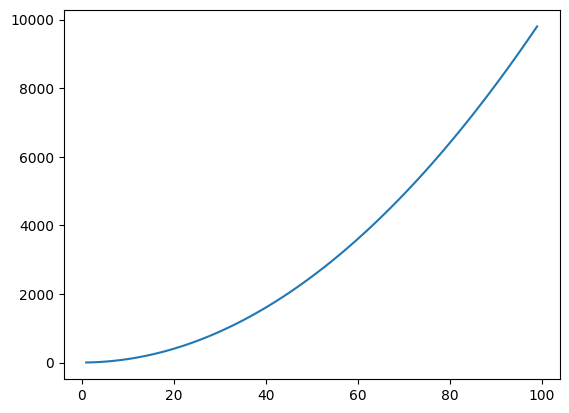

In [5]:
plt.plot(X,y)
plt.show()

In [6]:
print(df['X'].shape)

(99,)


In [7]:
Xtrain = np.array(df['X'][:int(0.8*len(X))]).reshape(-1,1)
ytrain = np.array(df['y'][:int(0.8*len(y))]).reshape(-1,1)
Xtest = np.array(df['X'][int(0.8*len(X)):]).reshape(-1,1)
ytest = np.array(df['y'][int(0.8*len(y)):]).reshape(-1,1)

In [8]:
print(Xtrain.shape)

(79, 1)


In [9]:
losses=[]

In [10]:
def getActivation(activation):
  def Relu(x):
    y=(x+np.sign(x)*x)/2
    return y
  def Identity(x):
    return x
  if activation == 'ReLu':
    return Relu
  elif activation == 'Identity':
    return Identity
  
def activationGradient(activation):
  def Relu(x):
    y=(1+np.sign(x))//2
    return y
  if activation == 'ReLu':
    return Relu

def getLoss(loss):
  def sse(y,y_pred):
      return np.sum((y-y_pred)**2)
  if loss == 'SumOfSquares':
    return sse

def getGradient(loss):
  def sse(y,y_pred):
      return -2*(y-y_pred)
  if loss == 'SumOfSquares':
    return sse

class Layer:
  def __init__(self,n_nodes,in_weights,biases,activation='ReLu'):
    #self.nodes=nodes
    #self.n_nodes=len(nodes)
    self.n_nodes = n_nodes
    self.in_weights=in_weights.T
    self.biases = biases
    self.y=np.array([0.0]*self.n_nodes)
    self.activation = activation

# class Node:
#   def __init__(self,incoming,bias):
#     self.incoming=incoming
#     self.bias=bias

class NNetwork:
  def __init__(self,n_in,n_hidden,n_out,nodes_per_layer=2):
    self.n_in=n_in
    self.n_out=n_out
    self.n_hidden=n_hidden
    self.nodes_per_layer = nodes_per_layer
    self.n_weights = 0
    self.Layers = []
    self.Layers.append(Layer(n_in,np.array([]),np.array([])))
    print("Gaussian : ",GaussianNoise(0,1,np.random.uniform(-1,1,size=(self.nodes_per_layer,self.n_in))))
    self.Layers.append(Layer(self.nodes_per_layer,np.array(GaussianNoise(0,1,np.random.uniform(-1,1,size=(self.nodes_per_layer,self.n_in)))),np.array([0.0]*self.nodes_per_layer)))
    for i in range(1,n_hidden):
      #self.Layers.append(Layer(self.nodes_per_layer))
      #nodes=[]
      incoming_edges_per_node=self.Layers[-1].n_nodes
      
      self.Layers.append(Layer(self.nodes_per_layer,np.array(GaussianNoise(0,1,np.random.uniform(-1,1,size=(self.nodes_per_layer,incoming_edges_per_node)))),np.array([0.0]*self.nodes_per_layer)))
    self.Layers.append(Layer(n_out,np.array(GaussianNoise(0,1,np.random.uniform(-1,1,size=(self.n_out,self.Layers[-1].n_nodes)))),np.array([0.0]*self.n_out),activation='Identity'))
    self.n_weights=self.n_in*self.Layers[0].n_nodes
    for i in range(1,len(self.Layers)-1):
      layer_weights_shape= self.Layers[i].in_weights.shape
      for r in range(layer_weights_shape[0]):
        for c in range(layer_weights_shape[1]):
          self.Layers[i].in_weights[r][c]= GaussianNoise(0,1,np.random.randint(-1,1))
          print(self.Layers[i].in_weights[r][c])
      print(layer_weights_shape)
      self.n_weights+= layer_weights_shape[0]*layer_weights_shape[1]
    self.weights = [0.0]*self.n_weights
  
  def NetworkStats(self):
    print("Total Layers : ", self.n_in+self.n_out+self.n_hidden)
    print("Total Hidden Layers : ", self.n_hidden)
    print("----LAYER 0----")
    print("Total Input : ", self.n_in)
    print("Len layers : ",len(self.Layers))
    for i in range (1,len(self.Layers)):
      print("----LAYER ",i,"----")
      print("Total Nodes : ", self.Layers[i].n_nodes)
      layer_weights_shape= self.Layers[i].in_weights.shape
      print("Total Incoming Edges per Node : ", layer_weights_shape[0]*layer_weights_shape[1])
      print("Total Biases : ", len(self.Layers[i].biases))
      print("Weights : ",self.Layers[i].in_weights)
    print("\nTotal Weights : ", self.n_weights)
  
  def BackPropogation(self,X,y_true,alpha=0.001,max_iter=1000,Loss="SumOfSquares"):
    print(X)
    if(len(np.array(X).shape)<2):
      print(" INVALID X SHAPE : ",X.shape)
    self.Layers[0].y = X
    grad = getGradient(Loss)
    lf = getLoss(Loss)
    #losses=[]
    for itr in range(max_iter):
      print("---ITR ",itr+1,"---")
      #forwardpass 
      ac=getActivation(self.Layers[1].activation)

      self.Layers[1].y = ac(np.dot(X,self.Layers[1].in_weights) + self.Layers[1].biases)
      # print(self.Layers[1].in_weights) 
      # print(np.dot(X,self.Layers[1].in_weights) )
      # print(ac(5*self.Layers[1].in_weights))
      # print("Layer 1 [0]: ",self.Layers[1].y[0][1])
      #print("Layer 1 y : ",self.Layers[1].y)
      for i in range(2,len(self.Layers)):
        #print(self.Layers[i].activation)
        ac=getActivation(self.Layers[i].activation)
        #print("Layer ",i," weights : ",self.Layers[i].in_weights)
        #np.dot(X.T,w) 
        self.Layers[i].y  = ac(np.dot(self.Layers[i-1].y,self.Layers[i].in_weights)+ self.Layers[i].biases)
        #print("Layer ",i," y : ",self.Layers[i].y)

      #print("After forward pass : ",np.sum(self.Layers[-1].y))
      #plt.plot()

      #BackPropogation
      n=len(X)
      #print(n)
      
      dLdy = grad(y_true,self.Layers[-1].y)
      #print("dLdy : ",dLdy," dLdy shape : ",dLdy.shape)
      print("Gradient of Loss : ",np.sum(dLdy))
      
      losses.append(lf(y_true,self.Layers[-1].y))
      print("LOSS : ",  losses[-1])
      #print("y shape ",self.Layers[-2].y.shape)
      dLdw = np.dot(self.Layers[-2].y.T,dLdy)
      # print("dLdw : ",dLdw)
      dLdb = np.sum(dLdy,axis=0)
      # print("dLdb : ",dLdb)
      dLdx=np.dot(dLdy,self.Layers[-1].in_weights.T)
      # print("dLdx : ",dLdx)
      #print("dldw ",dLdw.shape, " weights shape : ",self.Layers[-1].in_weights.shape)
      self.Layers[-1].in_weights-=alpha*dLdw/n
      self.Layers[-1].biases-=alpha*dLdb/n
      # print("Updated weights ",self.Layers[-1].in_weights)
      # print("Updated biases ",self.Layers[-1].biases)
      for j in range(1,len(self.Layers)-1):
        i=len(self.Layers)-j-1
        #print("---LAYER ",i,"---")
        acgrad = activationGradient(self.Layers[i].activation)
        dLdy=dLdx
        #print(dLdy.shape)
        dg = acgrad(np.dot(self.Layers[i-1].y,self.Layers[i].in_weights)+self.Layers[i].biases)
        #print("dg sum = ",np.sum(dg))
        #print("dg shape ",dg.shape)
        dLdb = np.sum(np.multiply(dg,dLdy),axis=0)
        #print(" dLdb shape ", dLdb.shape)
        #print("y shape ",np.sum(self.Layers[i-1].y,axis=0).shape)
        #print("dg shape ",dg.shape," y values shape for Layer",i-1," ",self.Layers[i-1].y.shape)
        #dLdw = np.sum(np.dot(self.Layers[i-1].y,np.dot(dLdy,dg)),axis=0)
        #print("dLdy shape : ",dLdy.shape)
        dLdw = np.dot(np.multiply(dg,dLdy).T,self.Layers[i-1].y)
        #print("dLdw : ",dLdw)
        #print("dLdw shape : ",dLdw.shape)
        #print("Weights shape : ",self.Layers[i].in_weights.shape)
        intermediate = np.multiply(dg,dLdy)
        #print("Intermediate : ",intermediate)
        dLdx = np.dot(intermediate,self.Layers[i].in_weights.T)
        #print("dLdx shape : ",dLdx.shape)
        #Update weights and biases 
        # print("dLdw : ",dLdw)
        # print("dLdb : ",dLdb)
        self.Layers[i].in_weights-=alpha*(dLdw.T)/n
        self.Layers[i].biases-=alpha*dLdb/n
        # print("Updated weights ",self.Layers[i].in_weights)
        # print("Updated biases ",self.Layers[i].biases)
    
  def predict(self,X):
    ac=getActivation(self.Layers[1].activation)
    self.Layers[1].y = ac(np.dot(X,self.Layers[1].in_weights) + self.Layers[1].biases)
    print("Layer 1 : ",np.sum(self.Layers[1].y))
    for i in range(2,len(self.Layers)):
      print(self.Layers[i].activation)
      ac=getActivation(self.Layers[i].activation)
      print("Layer ",i," weights : ",self.Layers[i].in_weights)
      #np.dot(X.T,w) 
      self.Layers[i].y  = ac(np.dot(self.Layers[i-1].y,self.Layers[i].in_weights)+ self.Layers[i].biases)
      print(i," ",self.Layers[i].y.shape)

    print("After forward pass : ",np.sum(self.Layers[-1].y))
    return self.Layers[-1].y



      


    

In [11]:
net = NNetwork(1,1,1)
net.NetworkStats()

Gaussian :  [[0.24888246]
 [0.33627909]]
0.24197072451914337
0.24197072451914337
(1, 2)
Total Layers :  3
Total Hidden Layers :  1
----LAYER 0----
Total Input :  1
Len layers :  3
----LAYER  1 ----
Total Nodes :  2
Total Incoming Edges per Node :  2
Total Biases :  2
Weights :  [[0.24197072 0.24197072]]
----LAYER  2 ----
Total Nodes :  1
Total Incoming Edges per Node :  2
Total Biases :  1
Weights :  [[0.36853353]
 [0.3496596 ]]

Total Weights :  3


In [12]:
net.Layers[0].in_weights

array([], dtype=float64)

In [13]:
losses=[]
net.BackPropogation(Xtrain,ytrain,alpha=1e-6,max_iter=1000)

[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]
 [44]
 [45]
 [46]
 [47]
 [48]
 [49]
 [50]
 [51]
 [52]
 [53]
 [54]
 [55]
 [56]
 [57]
 [58]
 [59]
 [60]
 [61]
 [62]
 [63]
 [64]
 [65]
 [66]
 [67]
 [68]
 [69]
 [70]
 [71]
 [72]
 [73]
 [74]
 [75]
 [76]
 [77]
 [78]
 [79]]
---ITR  1 ---
Gradient of Loss :  -333862.1837794627
LOSS :  631585093.0117474
---ITR  2 ---
Gradient of Loss :  -333193.8590168392
LOSS :  629482116.0335786
---ITR  3 ---
Gradient of Loss :  -332167.8978851957
LOSS :  626260712.7435699
---ITR  4 ---
Gradient of Loss :  -330576.63252352277
LOSS :  621281417.3406137
---ITR  5 ---
Gradient of Loss :  -328104.5769415118
LOSS :  613587765.1706481
---ITR  6 ---
Gradient of Loss :  -324274.78049580584
LOSS :  601769330.4874096
---ITR  7 ---
Gradient of Loss :  -318378.2973414

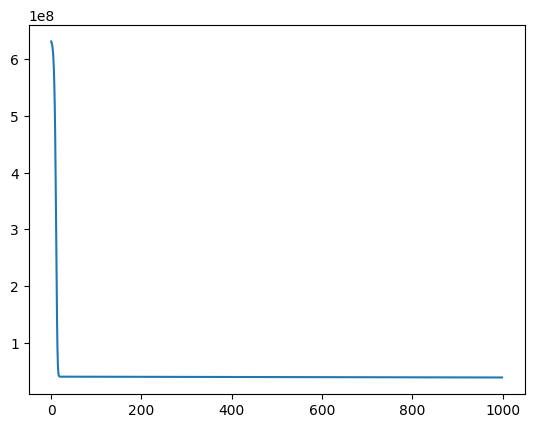

In [14]:
plt.plot(losses)

In [15]:
net.Layers[1].in_weights

array([[5.2246339 , 5.06331802]])

In [16]:
np.sum(net.Layers[2].y)

187850.28957535035

In [17]:
print(np.sum(ytrain))

167480.24210455475


In [18]:
print(np.sum((ytrain-net.Layers[2].y)**2))

38314708.94403147


In [19]:
net.predict(Xtrain)

Layer 1 :  32067.974238855415
Identity
Layer  2  weights :  [[5.9496135 ]
 [5.76549306]]
2   (79, 1)
After forward pass :  187849.57877183132


array([[  27.03675611],
       [  87.31383337],
       [ 147.59091063],
       [ 207.86798789],
       [ 268.14506515],
       [ 328.42214241],
       [ 388.69921967],
       [ 448.97629694],
       [ 509.2533742 ],
       [ 569.53045146],
       [ 629.80752872],
       [ 690.08460598],
       [ 750.36168324],
       [ 810.6387605 ],
       [ 870.91583776],
       [ 931.19291502],
       [ 991.46999228],
       [1051.74706954],
       [1112.0241468 ],
       [1172.30122406],
       [1232.57830132],
       [1292.85537858],
       [1353.13245584],
       [1413.4095331 ],
       [1473.68661036],
       [1533.96368762],
       [1594.24076488],
       [1654.51784214],
       [1714.7949194 ],
       [1775.07199666],
       [1835.34907392],
       [1895.62615118],
       [1955.90322844],
       [2016.1803057 ],
       [2076.45738296],
       [2136.73446022],
       [2197.01153748],
       [2257.28861474],
       [2317.565692  ],
       [2377.84276926],
       [2438.11984652],
       [2498.396

In [20]:
print(ytrain)

[[1.24197072e+00]
 [4.00013383e+00]
 [9.00000000e+00]
 [1.60000000e+01]
 [2.50000000e+01]
 [3.60000000e+01]
 [4.90000000e+01]
 [6.40000000e+01]
 [8.10000000e+01]
 [1.00000000e+02]
 [1.21000000e+02]
 [1.44000000e+02]
 [1.69000000e+02]
 [1.96000000e+02]
 [2.25000000e+02]
 [2.56000000e+02]
 [2.89000000e+02]
 [3.24000000e+02]
 [3.61000000e+02]
 [4.00000000e+02]
 [4.41000000e+02]
 [4.84000000e+02]
 [5.29000000e+02]
 [5.76000000e+02]
 [6.25000000e+02]
 [6.76000000e+02]
 [7.29000000e+02]
 [7.84000000e+02]
 [8.41000000e+02]
 [9.00000000e+02]
 [9.61000000e+02]
 [1.02400000e+03]
 [1.08900000e+03]
 [1.15600000e+03]
 [1.22500000e+03]
 [1.29600000e+03]
 [1.36900000e+03]
 [1.44400000e+03]
 [1.52100000e+03]
 [1.60000000e+03]
 [1.68100000e+03]
 [1.76400000e+03]
 [1.84900000e+03]
 [1.93600000e+03]
 [2.02500000e+03]
 [2.11600000e+03]
 [2.20900000e+03]
 [2.30400000e+03]
 [2.40100000e+03]
 [2.50000000e+03]
 [2.60100000e+03]
 [2.70400000e+03]
 [2.80900000e+03]
 [2.91600000e+03]
 [3.02500000e+03]
 [3.136000

In [21]:
net.predict(Xtest)

Layer 1 :  18303.546887299046
Identity
Layer  2  weights :  [[5.9496135 ]
 [5.76549306]]
2   (20, 1)
After forward pass :  107231.16187294059


array([[4788.92585967],
       [4849.20293693],
       [4909.4800142 ],
       [4969.75709146],
       [5030.03416872],
       [5090.31124598],
       [5150.58832324],
       [5210.8654005 ],
       [5271.14247776],
       [5331.41955502],
       [5391.69663228],
       [5451.97370954],
       [5512.2507868 ],
       [5572.52786406],
       [5632.80494132],
       [5693.08201858],
       [5753.35909584],
       [5813.6361731 ],
       [5873.91325036],
       [5934.19032762]])

In [22]:
# a=[-1,-2,-3,5,6,7,8]
# b=(a+np.sign(a)*a)//2
# print(b)